In [1]:
#Neural Network Library
import numpy as np
import pickle as pkl

class Layer:
    def forward(self):
        pass

    def backward(self):
        pass

class LinearLayer(Layer):
    def __init__(self, ip_size, op_size):
      super().__init__()

      lim = np.sqrt(6 / (ip_size + op_size))
      self.weights = np.random.uniform(-lim, lim, (ip_size, op_size))
      self.biases = np.random.uniform(-lim, lim, (1, op_size))

    def forward(self, ip):
        self.ip = ip
        return np.dot(ip, self.weights) + self.biases

    def backward(self, go, alpha = 0.1):
        gw = np.dot(self.ip.T, go)
        gb = np.sum(go, axis=0, keepdims = True)
        gi = np.dot(go, self.weights.T)
        self.weights -= gw * alpha
        self.biases -= gb * alpha
        return gi

class SigmoidAct(Layer):
    def forward(self, ip):
        ip_clipped = np.clip(ip, -np.log(np.finfo(np.float32).max), np.log(np.finfo(np.float32).max))
        self.op = 1 / (1 + np.exp(-ip_clipped))
        return self.op

    def backward(self, go, alpha = 0.1):
        return go * (self.op * (1 - self.op))

class ReLu(Layer):
    def forward(self, ip):
        self.ip = ip
        return np.maximum(0, ip)

    def backward(self, go, alpha = None):
        gi = go * (self.ip > 0)
        return gi

class HyperTan(Layer):
    def forward(self, ip):
        self.op = np.tanh(ip)
        return self.op

    def backward(self, go, apha =0.1):
        return go * (1 - self.op ** 2)

class BCEL(Layer):
    def forward(self, pred, op):
        pred_clipped = np.clip(pred, 1e-7, 1 - 1e-7)
        return -np.mean(op * np.log(pred_clipped) + (1 - op) * np.log(1 - pred_clipped))

    def backward(self, pred, op):
        pred_clipped = np.clip(pred, 1e-7, 1 - 1e-7)
        g = (pred_clipped - op)/(pred_clipped * (1 - pred_clipped))
        return g/pred_clipped.shape[0]

class Seq(Layer):
    def __init__(self, layers=None):
        self.layers = layers if layers is not None else []

    def apd(self, layer):
        self.layers.append(layer)

    def forward(self, ip):
        for layer in self.layers:
            ip = layer.forward(ip)
        return ip

    def backward(self, go, alpha = 0.1):
        for layer in reversed(self.layers):
            go = layer.backward(go, alpha)
        #return go

    def save(self, file):
        with open(file, 'wb') as fp:
            pkl.dump(self, fp)

    def load(self, file):
        with open(file, 'rb') as fp:
            self.__dict__.update(pkl.load(fp).__dict__)


# Part 1

In [7]:
#part 1: XOR problem
def train_network_xor(network, x, y, epochs=10000, learning_rate=0.1):
    loss_hist = []
    for epoch in range(epochs):
        predictions = network.forward(x)
        # BCEL
        loss = BCEL().forward(predictions, y)
        loss_hist.append(loss)
        grad_loss = BCEL().backward(predictions, y) / y.size
        network.backward(grad_loss)

        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, Loss: {loss}")

    return loss_hist

# Inputs and outputs setup for the XOR problem
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([[0], [1], [1], [0]])

learning_rate = 0.1
np.random.seed(42)
# Sigmoid Activation Network Setup
SigNetwork = Seq([
    LinearLayer(2, 2),
    SigmoidAct(),
    LinearLayer(2, 1),
    SigmoidAct()
])
loss_hist_sigmoid = train_network_xor(SigNetwork, x, y)
np.random.seed(42)
# Hyperbolic Tangent Activation Network Setup
HtNetwork = Seq([
    LinearLayer(2, 2),
    HyperTan(),
    LinearLayer(2, 1),
    HyperTan()
])
loss_hist_tanh = train_network_xor(HtNetwork, x, y)

#Save the Better Performing Model
best_model, best_loss_hist, best_loss = (SigNetwork, loss_hist_sigmoid, 'Sigmoid') if min(loss_hist_sigmoid) < min(loss_hist_tanh) else (HtNetwork, loss_hist_tanh, 'Hyperbolic Tangent')
best_model.save('XOR_solved.w') 

# Print output of best models
print(f"Minimum Loss with Sigmoid Activation: {min(loss_hist_sigmoid)}")
print(f"Minimum Loss with Hyperbolic Tangent Activation: {min(loss_hist_tanh)}")
print(f"The {best_loss} network performed better and was saved as 'XOR_solved.w'.")


Epoch 0, Loss: 0.7149963164751073
Epoch 1000, Loss: 0.6955188132704107
Epoch 2000, Loss: 0.6938010260572636
Epoch 3000, Loss: 0.6927962064942359
Epoch 4000, Loss: 0.6919188405602257
Epoch 5000, Loss: 0.6907334991020461
Epoch 6000, Loss: 0.6885177103759698
Epoch 7000, Loss: 0.6836016820459935
Epoch 8000, Loss: 0.672594886784511
Epoch 9000, Loss: 0.6509168952137163
Epoch 0, Loss: 1.3935857335960962
Epoch 1000, Loss: 0.04501215732815503
Epoch 2000, Loss: 0.012063479878584646
Epoch 3000, Loss: 0.006536130460108653
Epoch 4000, Loss: 0.0044062645418950835
Epoch 5000, Loss: 0.003298435704827585
Epoch 6000, Loss: 0.002624994682560905
Epoch 7000, Loss: 0.002174435677319774
Epoch 8000, Loss: 0.0018527641617485672
Epoch 9000, Loss: 0.0016120743804308574
Minimum Loss with Sigmoid Activation: 0.6127742361951167
Minimum Loss with Hyperbolic Tangent Activation: 0.0014256357153351938
The Hyperbolic Tangent network performed better and was saved as 'XOR_solved.w'.


In this training, the Hyperbolic Tangent activation model has generated minimum loss by using BinaryCross Entropy loss as loss function when compared to sigmoid activation function. Both the sigmoid and Hyperbolic tangent performs good but Hyperbolic tangent was easier to train when compared to sigmoid. 

# Part 2

In [3]:
#for distance calculation using latitude and longitude
#run only if the package is not installed
pip install haversine

SyntaxError: invalid syntax (3359060223.py, line 3)

import libraries

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
from haversine import haversine


C:\Users\vedas\AppData\Local\Temp\ipykernel_10016\3387611097.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Load the dataset


In [5]:
#Referenced from the assignment
dataset = np.load("nyc_taxi_data.npy", allow_pickle=True).item()
X_train, y_train, X_test, y_test = dataset["X_train"], dataset["y_train"], dataset["X_test"], dataset["y_test"]

Shape of the data

In [6]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1312779, 10), (1312779,), (145865, 10), (145865,))

Data preprocessing

In [7]:
def dist(x):
  p = (x['pickup_latitude'], x['pickup_longitude'])
  d = (x['dropoff_latitude'], x['dropoff_longitude'])

  dis = haversine(p,d)

  return  dis

def prep(dataframe):
    dataframe['pickup_datetime'] = pd.to_datetime(dataframe['pickup_datetime'])
    dataframe['dropoff_datetime'] = pd.to_datetime(dataframe['dropoff_datetime'])

    dataframe['pickup_hour'] = dataframe['pickup_datetime'].dt.hour
    dataframe['pickup_day_of_week'] = dataframe['pickup_datetime'].dt.dayofweek
    dataframe['pickup_month'] = dataframe['pickup_datetime'].dt.month

    dataframe['dropoff_hour'] = dataframe['dropoff_datetime'].dt.hour
    dataframe['dropoff_day_of_week'] = dataframe['dropoff_datetime'].dt.dayofweek
    dataframe['dropoff_month'] = dataframe['dropoff_datetime'].dt.month

    encoder = LabelEncoder()
    dataframe['store_and_fwd_flag'] = encoder.fit_transform(dataframe['store_and_fwd_flag'])
    dataframe['trip_distance'] = dataframe.apply(dist, axis=1)

    return dataframe


Refer to the Data analysis.ipynb file for additional details

Training and Testing methods

In [8]:
def score(pred, y):
  pred = np.maximum(0, pred)
  y = np.maximum(0, y)
  logp = np.log1p(pred)
  logy = np.log1p(y)

  n = logp - logy
  e = np.mean(n ** 2)

  return n , np.sqrt(e)

def train_val(model, X, y, epochs, btch_size, alpha, x_sc, y_sc, stop = 5):
  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.01, random_state = 40)
  y_val = y_sc.inverse_transform(y_val.reshape(-1,1)).flatten()
  loss_train = []
  loss_val = []
  best_loss_val = float('inf')
  val_count = 0
  y_val = y_val.reshape(-1,1)

  for epoch in range(epochs):
    for i in range(0, len(X_train), btch_size):
      X = X_train[i : i + btch_size]
      y = y_train[i : i + btch_size].reshape(-1,1)
      y_pred = model.forward(X)
      y_pred = y_sc.inverse_transform(y_pred.reshape(-1,1)).flatten()
      y = y_sc.inverse_transform(y.reshape(-1,1)).flatten()
      dl, loss = score(y_pred, y)
      loss_train.append(loss)
      model.backward(dl.reshape(-1,1))

    y_pred = model.forward(X_val)
    y_pred = y_sc.inverse_transform(y_pred.reshape(-1,1)).flatten()
    dl, loss = score(y_pred, y_val)
    score_val = loss
    loss_val.append(score_val)

    if score_val < best_loss_val:
      best_loss_val = score_val
      val_count = 0
    else:
      val_count += 1

    if val_count >= stop:
      print("Early stopping triggered at epoch", (epoch+1))
      break

  return model, loss_train, loss_val

def test(model, X, y, X_sc, y_sc):
  y = y_sc.inverse_transform(y.reshape(-1,1)).flatten()
  y_pred = model.forward(X)
  y_pred = y_sc.inverse_transform(y_pred.reshape(-1,1)).flatten()
  dl, loss = score(y_pred, y)
  return loss

def plot(t, v):
  #training loss plot
  plt.figure(figsize = (10,6))
  plt.plot(t, label = 'Training Loss')
  plt.title('Training Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  plt.show()

  #validation loss plot
  plt.figure(figsize = (10,6))
  plt.plot(v, label = 'Validation Loss')
  plt.title('Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  plt.show()

def norm(df, y, f, X_sc = None, y_sc = None):
  if not X_sc:
    X_sc = StandardScaler()
    X_sc.fit(df[f])

  if not y_sc:
    y_sc = StandardScaler()
    y_sc.fit(y.values.reshape(-1,1))

  X_scaled = X_sc.transform(df[f])
  y_scaled = y_sc.transform(y.values.reshape(-1,1)).flatten()

  return (X_scaled, y_scaled, X_sc, y_sc)

# Model 1

Early stopping triggered at epoch 4


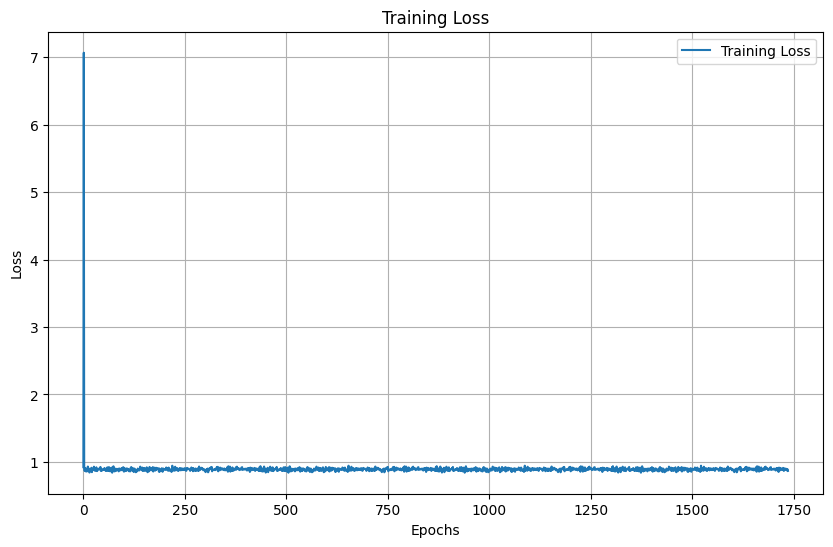

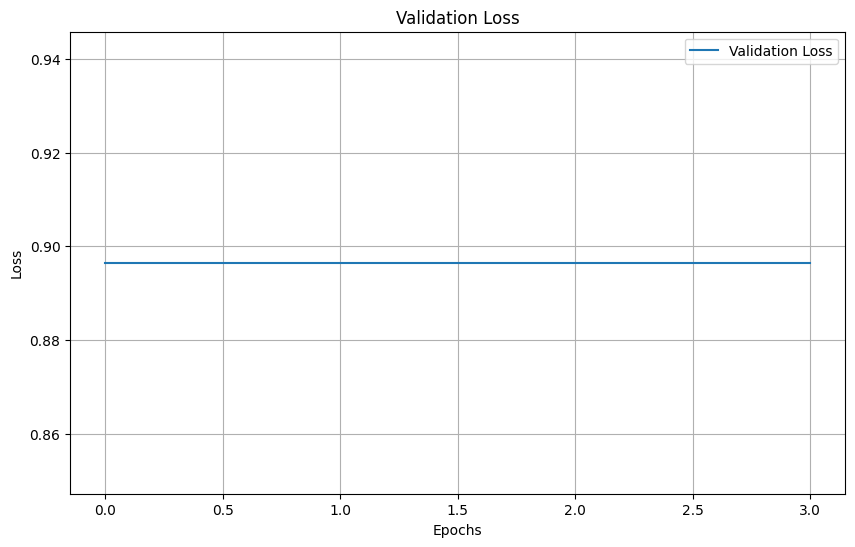

In [9]:
f = ['passenger_count', 'pickup_hour', 'dropoff_hour', 'pickup_day_of_week', 'pickup_month', 'trip_distance']
df = X_train
df = prep(df)
X, y, X_sc, y_sc = norm(df, y_train, f)
n = X.shape[1]

X_ts = prep(X_test)
X_ts, y_ts, _, _ = norm(X_ts, y_test, f, X_sc, y_sc)

epochs = 100
alpha = 0.01
batch =3000
stop = 3

model = Seq([LinearLayer(n, 800),
             ReLu(),
             LinearLayer(800, 800),
             ReLu(),
             LinearLayer(800, 1),
             ReLu()]
            )
model, t, v, = train_val(model, X, y, epochs, batch, alpha, X_sc, y_sc, stop)
plot(t,v)


In [10]:
pred_test = test(model, X_ts, y_ts, X_sc, y_sc)

print(pred_test,'RMSLE')

0.8933073319363067 RMSLE


Model 1 was created in 3 layers using Relu activations. This model was trained till epoch 4 until early stopping was triggered. This model gave a score of 0.8933.
Features: 'passenger_count', 'pickup_hour', 'pickup_hour', 'pickup_day_of_week', 'pickup_month', 'trip_distance', 'dropoff_hour'.
The training and validation loss is plotted above.

# Model 2

Early stopping triggered at epoch 4


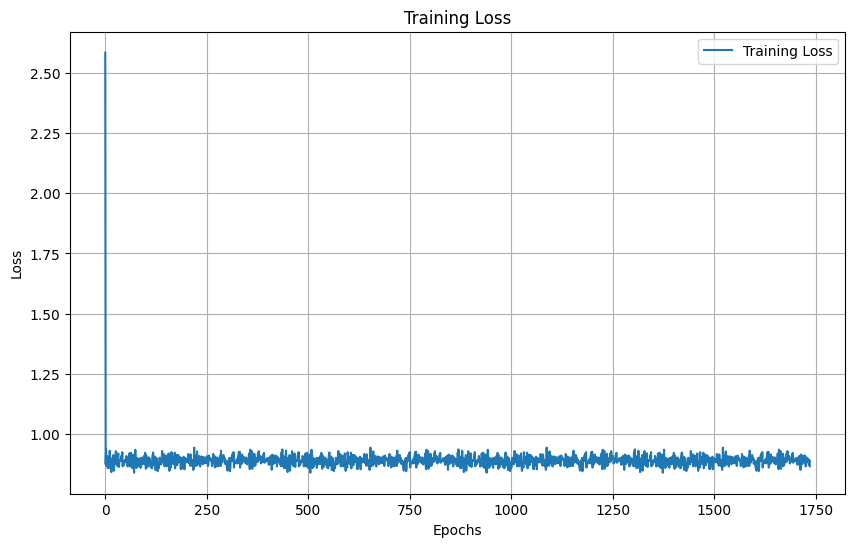

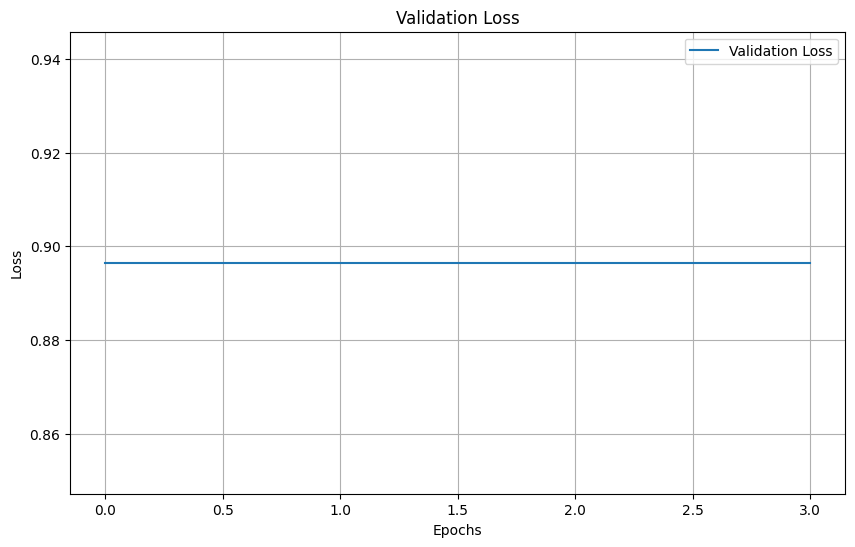

In [11]:
f = [   ]
df = X_train
df = prep(df)
X, y, X_sc, y_sc = norm(df, y_train, f)
n = X.shape[1]

X_ts = prep(X_test)
X_ts, y_ts, _, _ = norm(X_ts, y_test, f, X_sc, y_sc)

epochs = 100
alpha = 0.01
batch =3000
stop = 3

model = Seq([LinearLayer(n, 200),
             SigmoidAct(),
             LinearLayer(200, 1),
             ReLu(),
             ]
            )
model, t, v, = train_val(model, X, y, epochs, batch, alpha, X_sc, y_sc, stop)
plot(t,v)


In [12]:
pred_test = test(model, X_ts, y_ts, X_sc, y_sc)
print(pred_test,'RMSLE')


0.8933073319363067 RMSLE


Model 2 was created in 2 layers using sigmoid and Relu activations. This model was trained till epoch 4 until early stopping was triggered. This model gave a score of 0.89 RMSLE.
Features: 'passenger_count', 'pickup_hour','pickup_day_of_week', 'pickup_month', 'trip_distance', 'dropoff_hour', 'dropoff_month'.
The training and validation loss is plotted above.

# Model 3

Early stopping triggered at epoch 4


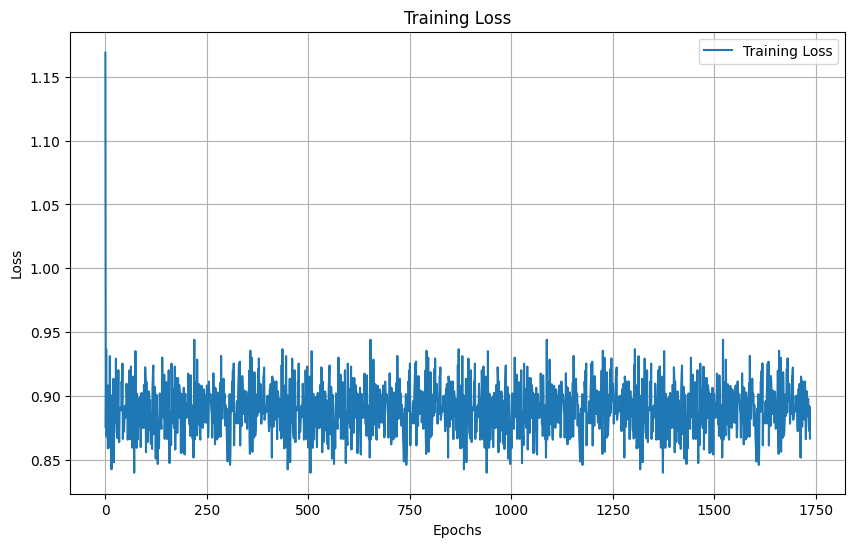

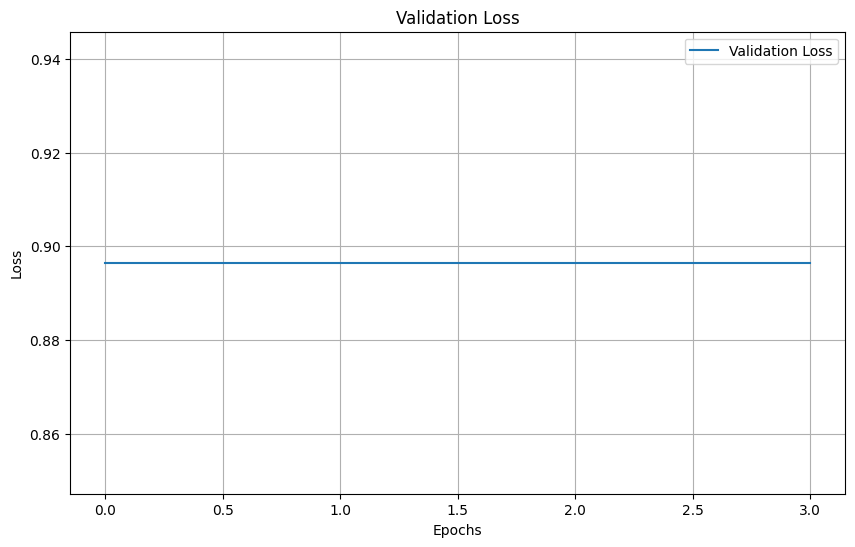

In [13]:
f = ['passenger_count', 'pickup_hour', 'dropoff_hour', 'pickup_day_of_week' ,'pickup_month', 'dropoff_month', 'dropoff_day_of_week', 'trip_distance']
df = X_train
df = prep(df)
X, y, X_sc, y_sc = norm(df, y_train, f)
n = X.shape[1]

X_ts = prep(X_test)
X_ts, y_ts, _, _ = norm(X_ts, y_test, f, X_sc, y_sc)

epochs = 100
alpha = 0.01
batch =3000
stop = 3

model = Seq([LinearLayer(n, 200),
             ReLu(),
             LinearLayer(200, 1),
             ReLu(),
             ]
            )
model, t, v, = train_val(model, X, y, epochs, batch, alpha, X_sc, y_sc, stop)
plot(t,v)


In [14]:
pred_test = test(model, X_ts, y_ts, X_sc, y_sc)
print(pred_test,'RMSLE')

0.8933073319363067 RMSLE


Model 3 was created in 2 layers using sigmoid and Relu activations. This model was trained till epoch 4 until early stopping was triggered. This model gave a score of 0.893307 RMSLE.
Features: 'passenger_count', 'pickup_hour', 'dropoff_hour', 'pickup_day_of_week' ,'pickup_month', 'dropoff_month', 'dropoff_day_of_week', 'trip_distance'.
The training and validation loss is plotted above.